# [Part 2] - In-Bed posture classification using CNN

This notebook belongs to a 4-parts project. This part is dedicated to build a model dedicated to classify human in-bed positions. On part one we tested a shallow model using a fully connected Multi-Layer-Perceptron. Now we want to improve our results and make a an analysis, via cross-validation, allowing us to obtain a good estimate of the test set and ensuring that the result does not overestimate the model's performance.

In [1]:
# Data Load
import os
import numpy as np

# PyTorch (modeling)
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import random_split
from torch.utils.data import DataLoader

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Our helper (takes a while because we load all data there as well)
import helper

# Data Preparation

## Data Loading

First we will load our datasets using our helper functions found on `helper.py`. Then we will gather all datasets into a dictionary:

In [2]:
exp_i_data = helper.load_exp_i("dataset/experiment-i")
exp_ii_data_air, exp_ii_data_spo = helper.load_exp_ii("dataset/experiment-ii")

datasets = {
    "Base":exp_i_data,
    "Spo":exp_ii_data_air,
    "Air":exp_ii_data_spo
}

## Creating a custom class

From the latter dictionary, `datasets`, we will create a custom **Dataset** class that we are going to use for our modeling. The idea is to define a class flexible enough so we can pull any subject data from any of the experiments.  For example, if our class is called `Mat_Dataset` and we we want to load the data of the subject n°1 and n°2 of the second experiment's sponge mat, then we would need to write:

`Mat_Dataset(mats=["Spo"], Subject_IDs=["S1", "S2"])`

We can take advantage of PyTorch's `Dataset` class to create ours. We just need to override two of the subclass functions:

+ the `len()` function (returns the size of the dataset)
+ the `getitem` function (returns a sample from the dataset)

In [3]:
from torch.utils.data import Dataset

class Mat_Dataset(Dataset):
  def __init__(self, mats, Subject_IDs):
    
    self.samples = []
    self.labels = []
    
    for mat in mats:
      data = datasets[mat]
      self.samples.append(np.vstack([data.get(key)[0] for key in Subject_IDs]))
      self.labels.append(np.hstack([data.get(key)[1] for key in Subject_IDs]))
      
    self.samples = np.vstack(self.samples)
    self.labels = np.hstack(self.labels)
    
  def __len__(self):
    return self.samples.shape[0]
      
  def __getitem__(self, idx):
    return self.samples[idx], self.labels[idx]

In [4]:
# Sanity check:
# 1. There are 29 files (recordings) on S1's experiment-ii/Sponge_Mat/
print(f'Sanity check 1: {len(Mat_Dataset(["Spo"], ["S1"]))}')
# 2. If we take into account the air mat, then there should be 58 files
print(f'Sanity check 2: {len(Mat_Dataset(["Spo", "Air"], ["S1"]))}')
# 3. Let's load all experiment-i data and check that it works:
print(f'Sanity check 3: {len(Mat_Dataset(["Base"], [key for key in exp_i_data.keys()]))}')


Sanity check 1: 29
Sanity check 2: 58
Sanity check 3: 19582


## Splitting the data into training and testing set

In [5]:
trainset_exp_i = Mat_Dataset(["Base"], ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9"])

valset_exp_i = Mat_Dataset(["Base"], ["S10", "S11", "S12", "S13"])

trainloader = DataLoader(trainset_exp_i, batch_size=64, shuffle=True)
testloader = DataLoader(valset_exp_i, batch_size=64, shuffle=False)

# Modeling

## The proposed Convolutional Neural Network (CNN)

Convolutional Neural Networks have proven [several times](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) to been a pioner architecture in the task of classifying images. We propose a simple network to solve our task.

In [6]:
class CNN(nn.Module):
  
  def __init__(self):
    super().__init__()

    ## Convolutional Layers
    #Input channels = 1, output channels = 6
    self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
    #Input channels = 6, output channels = 18
    self.conv2 = torch.nn.Conv2d(6, 18, kernel_size=3, stride=1, padding=1)

    ## Pool Layer
    self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ## Mulit-Layer Perceptron
    # Hidden layers
    self.h1 = nn.Linear(18 * 16 * 8, 392)
    self.h2 = nn.Linear(392, 98)

    # Output layer, 3 neurons - one for each position
    self.output = nn.Linear(98, 3)

    # ReLU activation and softmax output 
    self.relu = nn.ReLU()
    self.logsoftmax = nn.LogSoftmax(dim=1)

  def forward(self, x):

    x = x.float()
    # Add a "channel dimension"
    x = x.unsqueeze(1)

    ## Computation on convolutional and pool layers:
    # Size changes from (1, 64, 32) to (6, 64, 32)
    x = F.relu(self.conv1(x))
    # Size changes from (6, 64, 32) to (6, 32, 16)
    x = self.pool(x)
    # Size changes from (6, 32, 16) to (18, 32, 16)
    x = F.relu(self.conv2(x))
    # Size changes from (18, 32, 16) to (18, 16, 8)
    x = self.pool(x)

    # Reshape data to input to the input layer of the MLP
    # Size changes from (18, 16, 8) to (1, 2304)
    x = x.view(x.shape[0], -1)
    
    ## Computation on the MLP layers:
    x = self.h1(x)
    x = self.relu(x)
    x = self.h2(x)
    x = self.relu(x)
    x = self.output(x)
    x = self.logsoftmax(x)

    return x

Now we set our device, instantiate our model and set our loss function and optimizer.

In [7]:
torch.manual_seed(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
model = CNN()

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.0001)

model.to(device)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (h1): Linear(in_features=2304, out_features=392, bias=True)
  (h2): Linear(in_features=392, out_features=98, bias=True)
  (output): Linear(in_features=98, out_features=3, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
)

In [9]:
epochs = 5
running_loss = 0

train_losses, test_losses = [], []

for epoch in range(epochs):
  for inputs, labels in trainloader:
  
    inputs, labels = inputs.to(device), labels.to(device)
  
    optimizer.zero_grad()

    logps = model.forward(inputs)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  else:
    
    test_loss = 0
    accuracy = 0
    model.eval()
    
    with torch.no_grad():
      for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        test_loss += criterion(logps, labels)
        
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {running_loss/len(trainloader):.3f}.. "
          f"Test loss: {test_loss/len(testloader):.3f}.. "
          f"Test accuracy: {accuracy/len(testloader):.3f}")
    
    running_loss = 0
    model.train()

Epoch 1/5.. Train loss: 0.861.. Test loss: 0.472.. Test accuracy: 0.908
Epoch 2/5.. Train loss: 0.141.. Test loss: 0.103.. Test accuracy: 0.973
Epoch 3/5.. Train loss: 0.034.. Test loss: 0.085.. Test accuracy: 0.976
Epoch 4/5.. Train loss: 0.016.. Test loss: 0.094.. Test accuracy: 0.960
Epoch 5/5.. Train loss: 0.010.. Test loss: 0.100.. Test accuracy: 0.957


## Evaluation

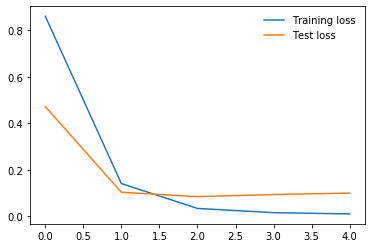

In [10]:
fig = plt.plot(train_losses, label='Training loss')
fig = plt.plot(test_losses, label='Test loss')
fig = plt.legend(frameon=False)  

Our model seems to work really well! Let's see it in action by plotting some images and the corresponding prediction:

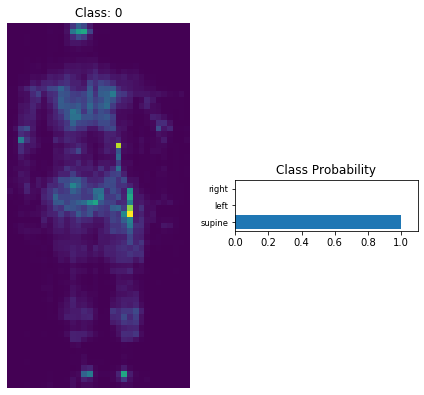

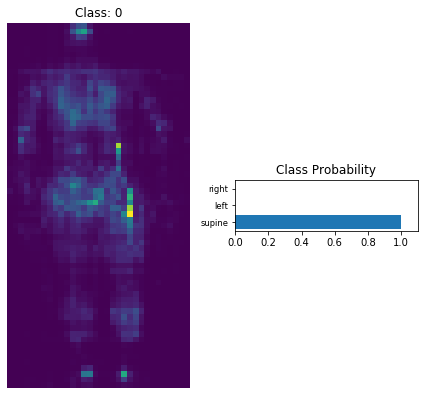

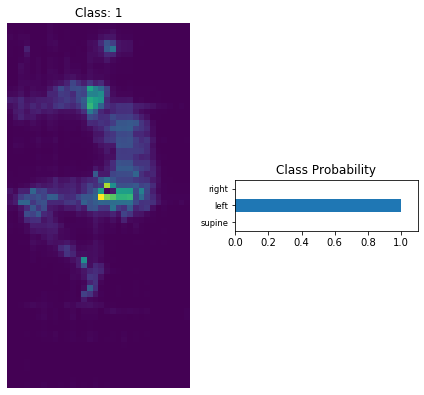

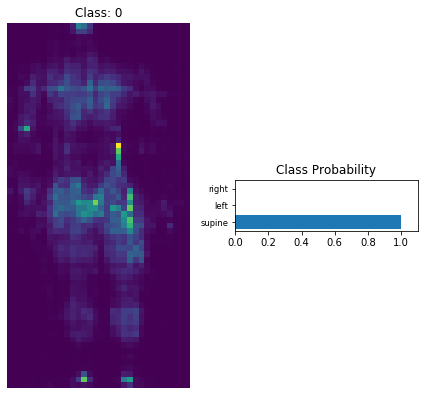

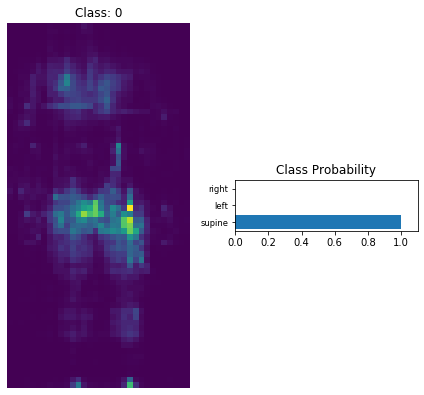

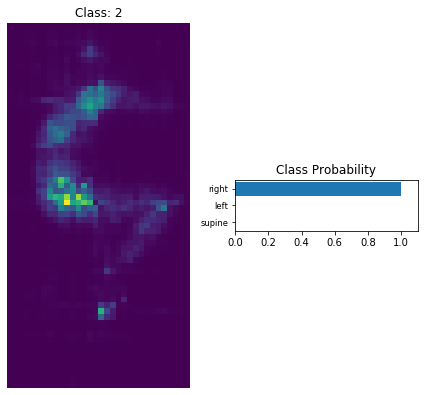

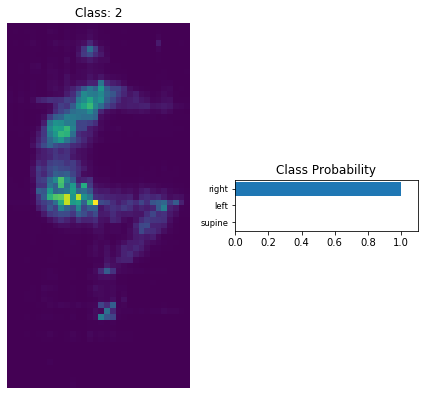

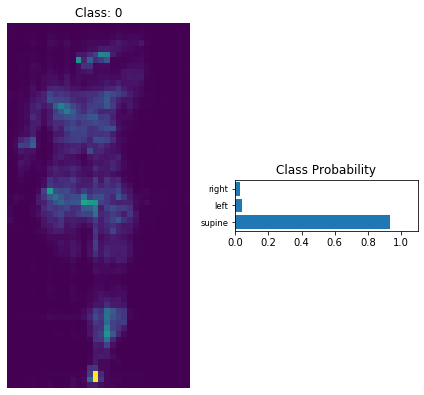

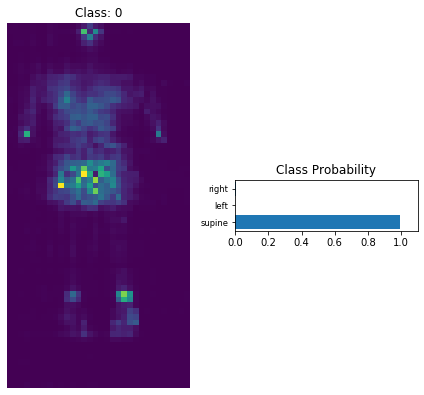

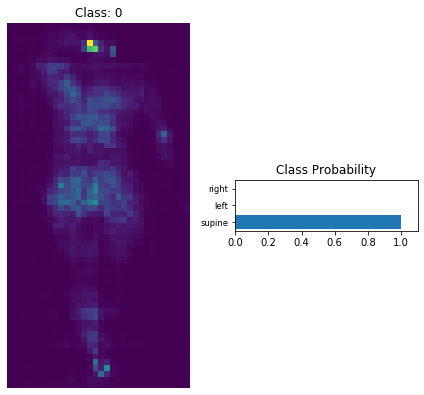

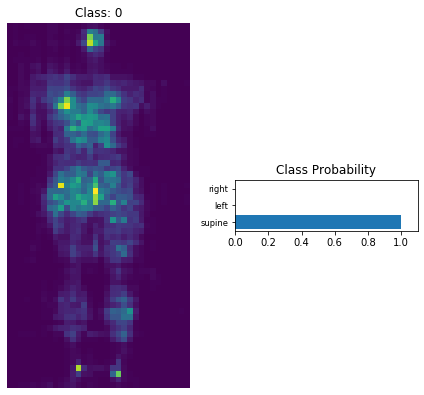

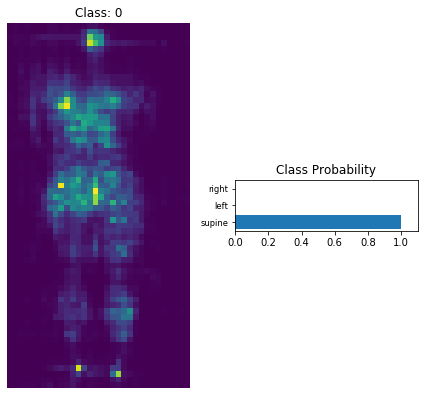

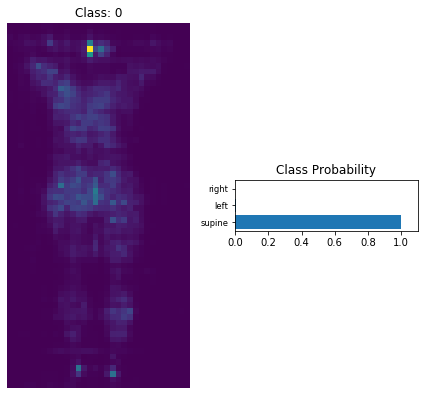

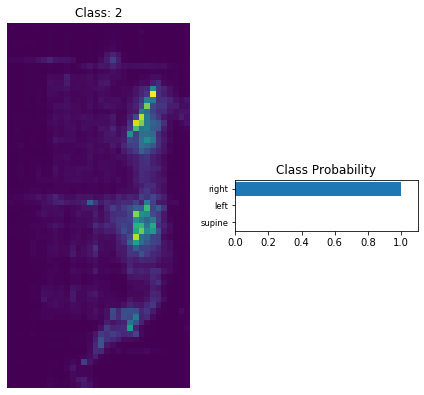

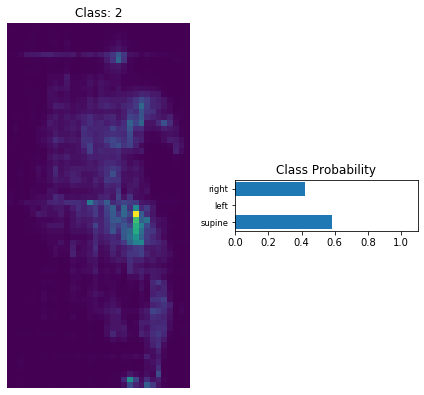

In [11]:
def class_position(img, ps, label):
  ''' Function for viewing an positioin and it's predicted classes.
  '''
  ps = ps.data.numpy().squeeze()

  fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
  ax1.imshow(img.resize_(1, 64, 32).numpy().squeeze())
  ax1.axis('off')
  ax1.set_title(f'Class: {label}') 
  ax2.barh(np.arange(3), ps)
  ax2.set_aspect(0.1)
  ax2.set_yticks(np.arange(3))

  ax2.set_yticklabels(['supine', 'left', 'right'], size='small');
  ax2.set_title('Class Probability')
  ax2.set_xlim(0, 1.1)

  plt.tight_layout()

plt.rcParams.update({'figure.max_open_warning': 0})

i = 1
for inputs, labels in testloader:
  inputs, labels = inputs.to(device), labels.to(device)
  class_position(inputs[0].unsqueeze(0).cpu(), torch.exp(model.forward(inputs[0].unsqueeze(0))).cpu(), labels[0].cpu())
  if i >= 15:
    break
  i += 1

We just obtained an estimate of the performance of our model with unseen data, where we purposely chose "S10", "S11", "S12", and "S13" as our test subjects. Now we want to perform a **leave-one-subject-out cross validation**, a technique that allow us to calculate a much better estimate for our model. Basically, the purpose is to select one subject as the testing set and use the rest as training, create and train a model, calculate its accuracy, and then repeat this procedure for all subjects. Finally, the mean value of all accuracies gives us the estimate of the performance of our model.

Since this technique involves only the repetition of code that we already introduced above, we created a function (found in `helper.py`)  `exp_i_cv()` for this purpose and we will just call it here to see the results, avoiding displaying redundant code in this notebook.

In [12]:
helper.exp_i_cv()

Performing one-subject-out cross validation on 'Experiment I':
Leave out: S1 - Test accuracy: 0.937
Leave out: S2 - Test accuracy: 0.891
Leave out: S3 - Test accuracy: 1.000
Leave out: S4 - Test accuracy: 0.933
Leave out: S5 - Test accuracy: 0.933
Leave out: S6 - Test accuracy: 0.999
Leave out: S7 - Test accuracy: 0.934
Leave out: S8 - Test accuracy: 0.997
Leave out: S9 - Test accuracy: 0.999
Leave out: S10 - Test accuracy: 0.865
Leave out: S11 - Test accuracy: 0.997
Leave out: S12 - Test accuracy: 0.994
Leave out: S13 - Test accuracy: 0.943
Results, one-subject-out cross validation: accuracy: 0.9554252624511719


Overall we obtained a great accuracy on this dataset, **which is greater** than the one reported by _Pouyan et. al (2017)_ on their [paper](https://ieeexplore.ieee.org/document/7897206/):

![Pouyan et. al - Results](img/Pouyan_et_al_Results.png) 

This positive result also stresses the advantages of using CNNs, compared with traditional methods such as the one used by the authors mentioned, where they performed a manual feature extraction and fed those features to a MLP.

## Testing the model on Experiment II data

We want to test how well does the model perform on data that was recorded on 'Experiment II', for that we will train a model using *all data* contained in 'Experiment I'. This training procedure is almost equal to what we just did, so we encapsulated it in a function: `train_all_exp_i()`



In [13]:
model, train_losses = helper.train_all_exp_i()

In [14]:
dataset_exp_ii = Mat_Dataset(["Spo", "Air"], exp_ii_data_spo.keys())

loader = DataLoader(dataset_exp_ii, batch_size=64, shuffle=False)
accuracy = 0

model.eval()
with torch.no_grad():
  for inputs, labels in loader:
    inputs, labels = inputs.to(device), labels.to(device)
    logps = model.forward(inputs)
    
    ps = torch.exp(logps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor))

print(f"Accuracy on Experiment II: {accuracy/len(loader):.3f}")

Accuracy on Experiment II: 0.578


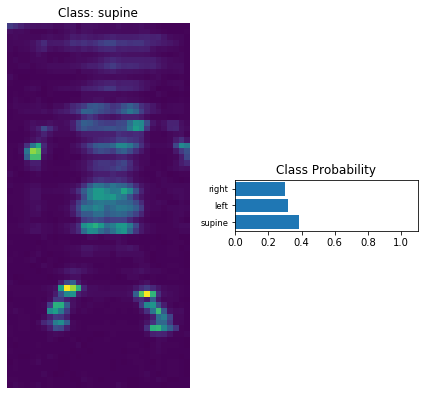

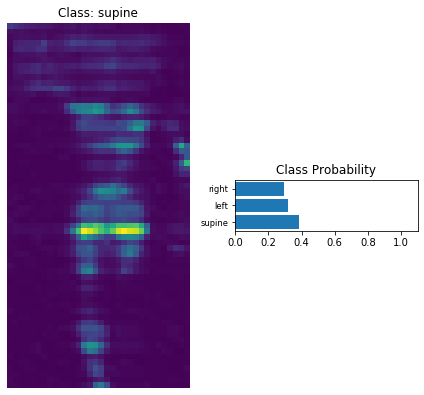

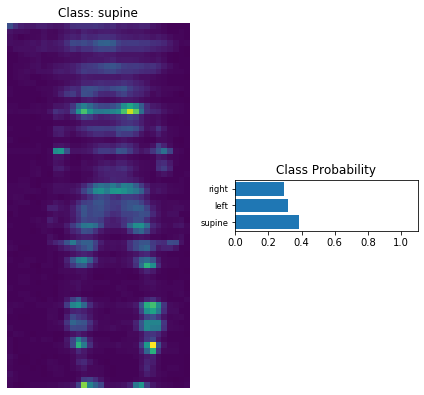

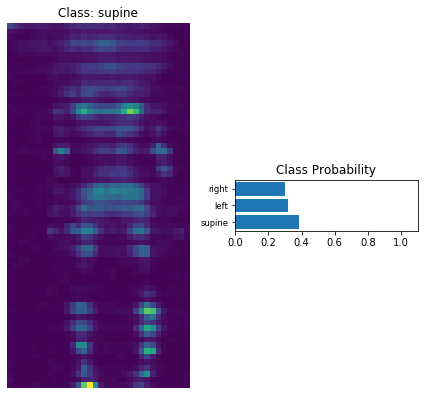

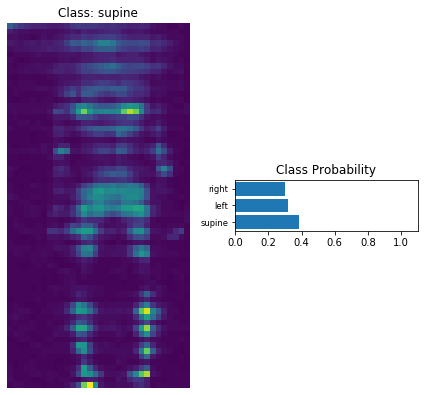

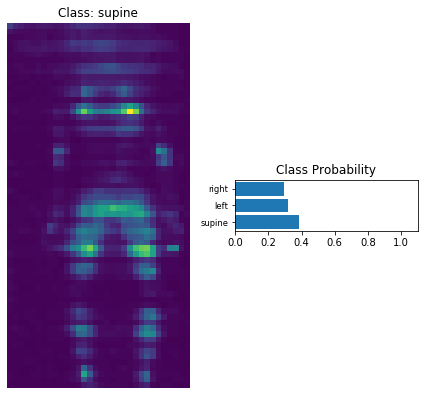

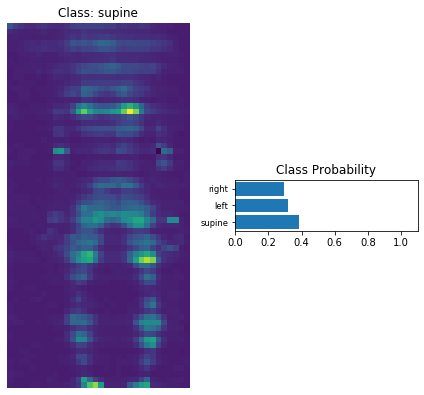

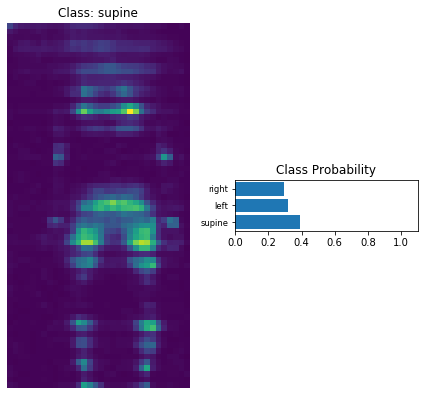

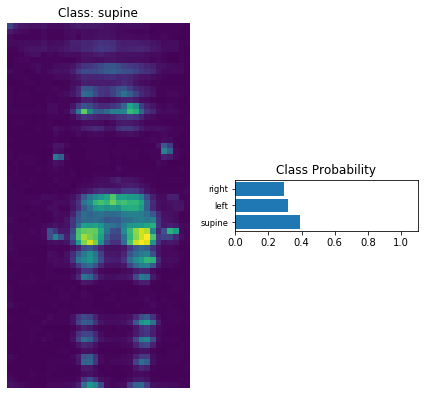

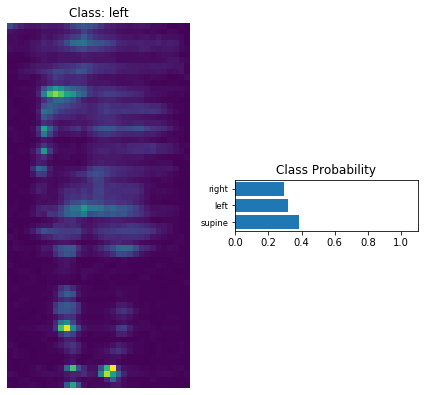

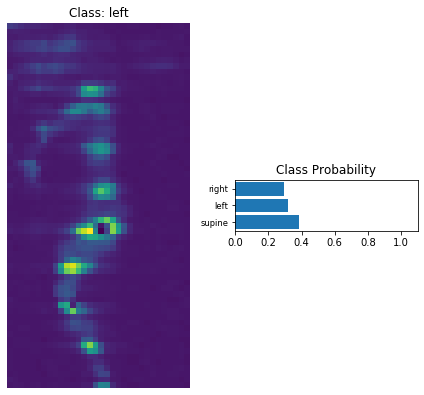

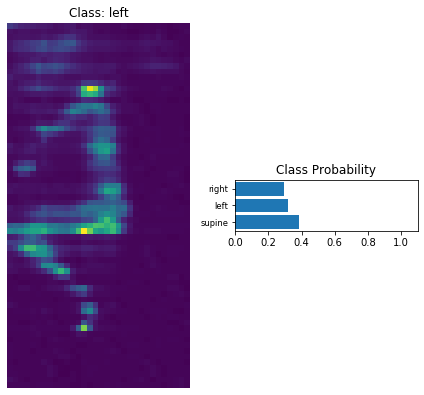

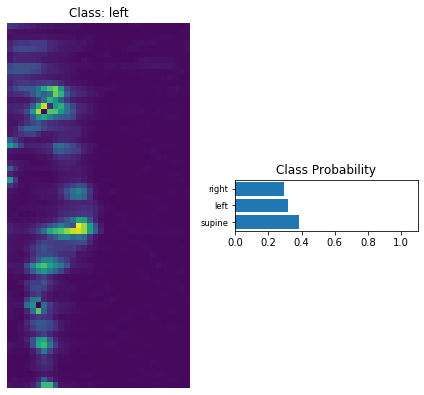

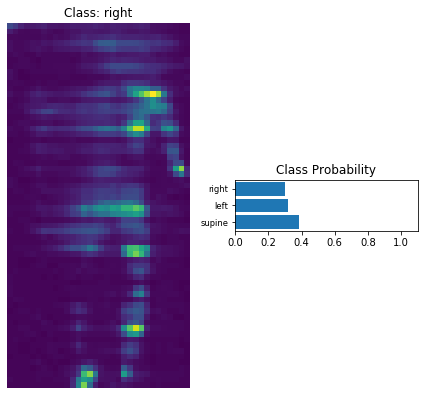

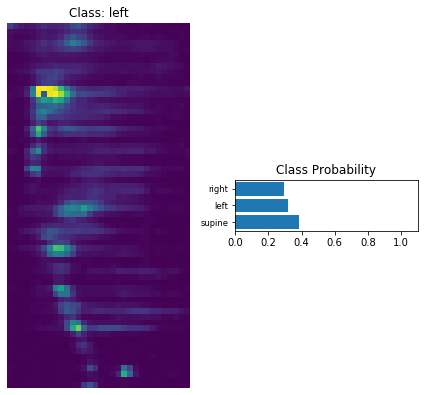

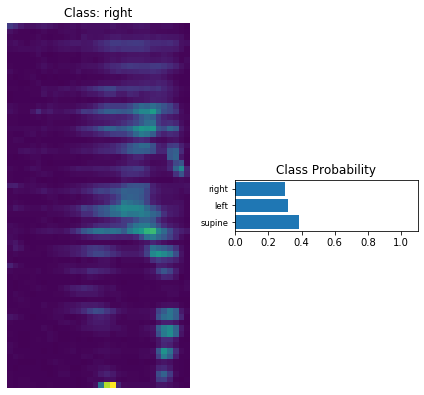

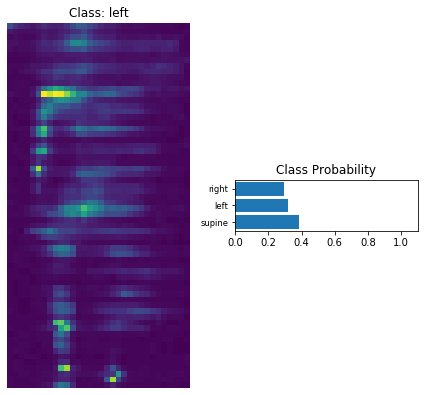

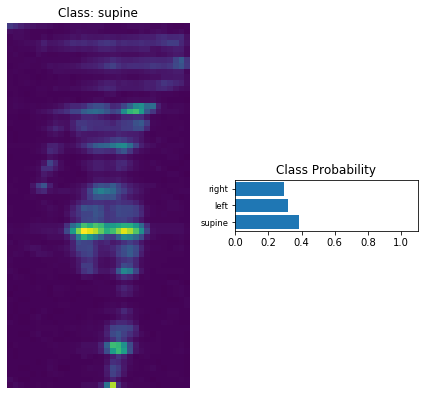

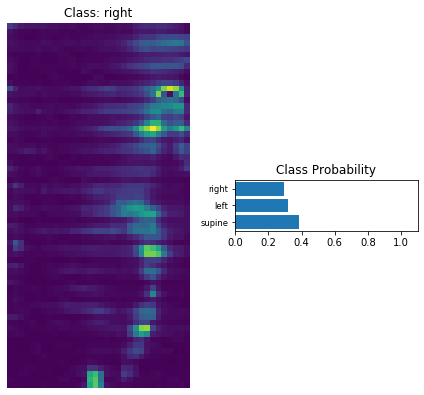

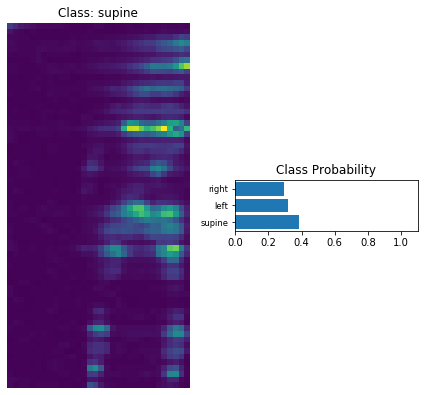

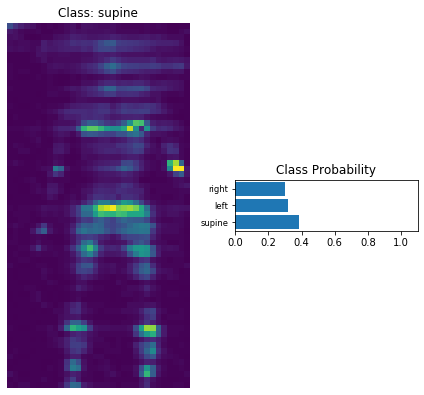

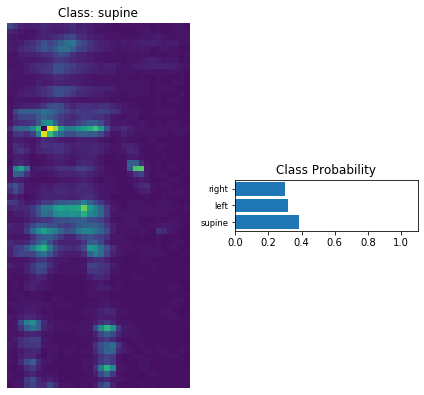

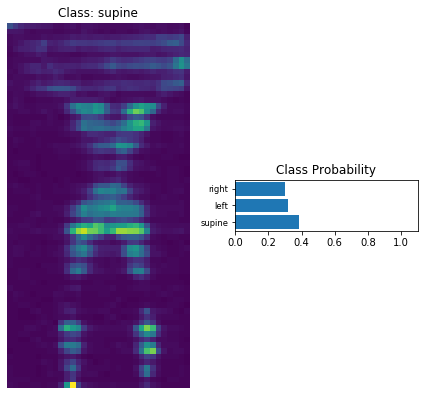

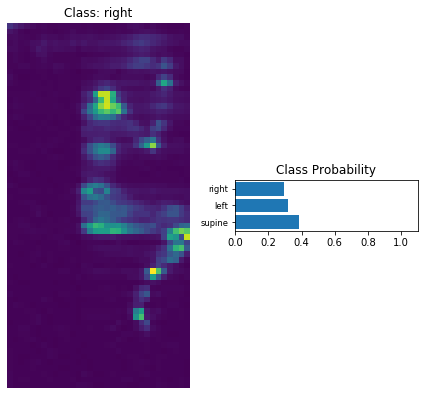

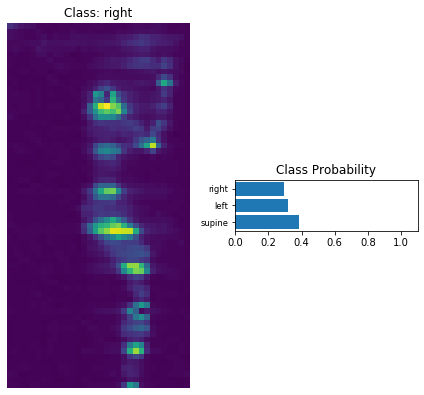

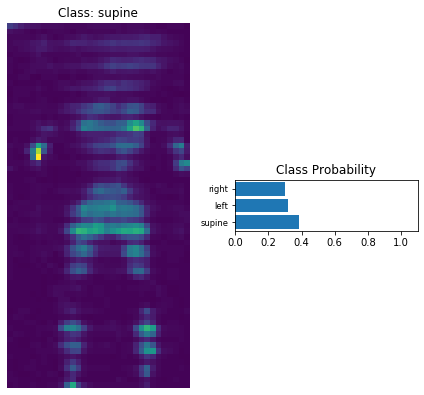

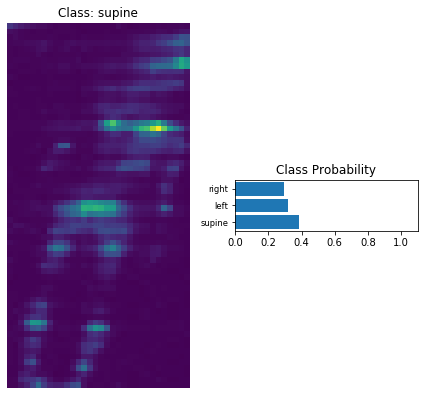

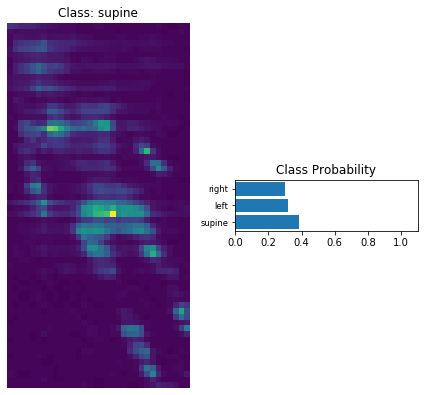

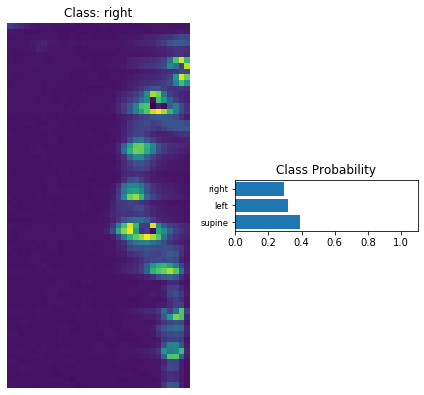

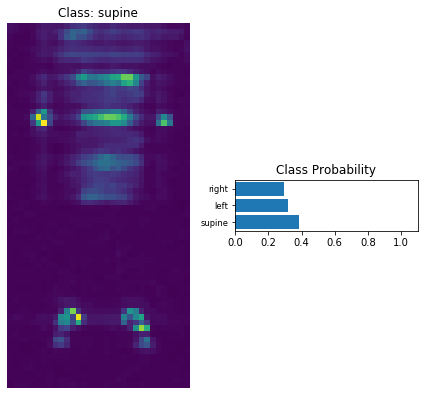

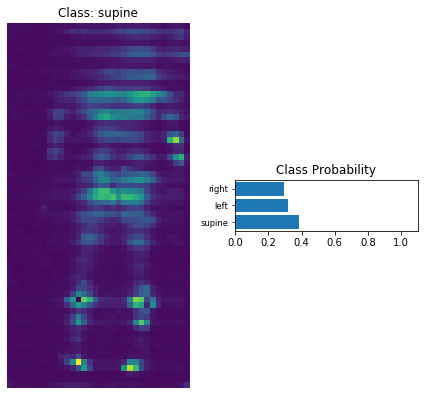

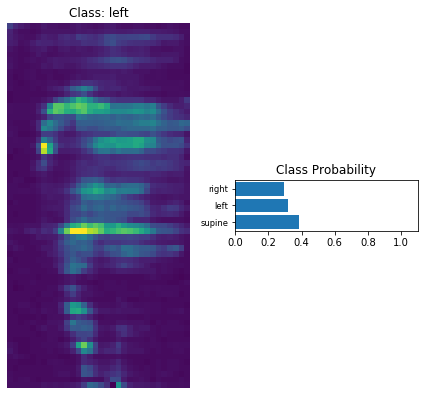

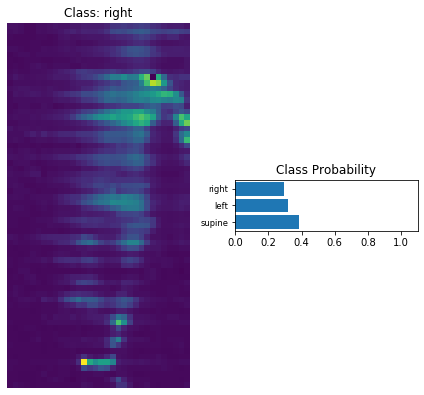

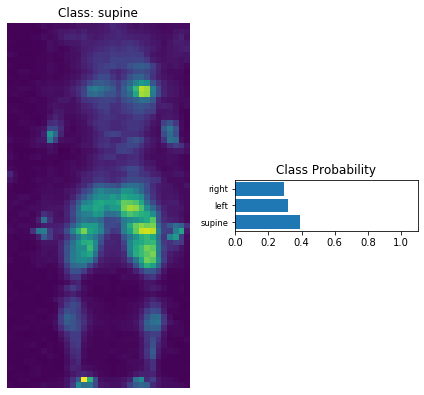

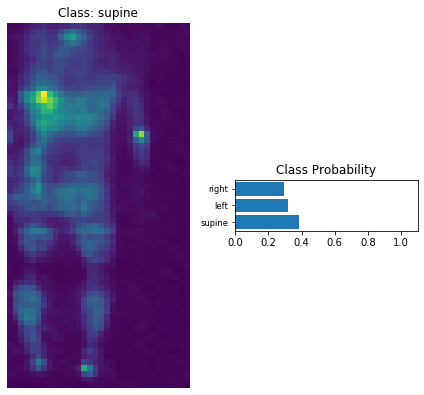

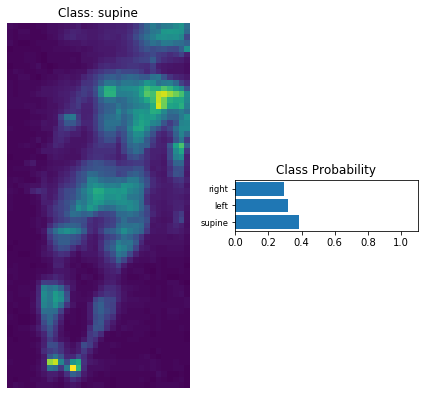

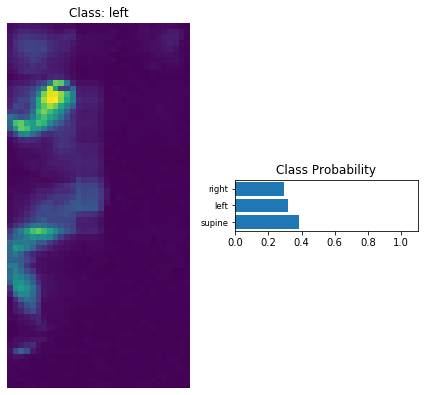

In [15]:
i = 1
for inputs, labels in loader:
  inputs, labels = inputs.to(device), labels.to(device)
  for j in range(labels.shape[0]):
    image = inputs[j]
    label = labels[j]
    img = image.unsqueeze(0).cpu()
    ps = torch.exp(model.forward(image.unsqueeze(0))).cpu()
    class_position(img, ps, helper.class_positions[label.cpu()])
    if i >= 30:
      break
    i += 1

## [Part 2] - Conclusions

We implemented a Convolutional Neural Network to solve the task of classifying the data and we analyzed via cross-validation its performance. Our results showed a greater accuracy with respect to the author's model, who used manual feature extraction to create vector inputs for a neural network.

We tested it's performance obtained a low accuracy on 'Experiment II' data. This results can be explained because:

+ There are new positions that were introduced in this dataset and did not occur on 'Experiment I'. For example, supine positions where the person lies diagonal with respect to the mattress.
+ Position alterations were introduced in Experiment II: supine positions could also occur on the right part of the mattress, while in 'Experiment I' this only occurred in the center.
+ Noise is introduced by the air mattress measurements and several of the measurements are really blurry even for the human eye.
+ There is one measurement per unique position per subject, meaning that the introduced new images have a high weight on the overall accuracy of the model.

We might cope with these difficulties by introducing several transformations to the training data (e.g., calling `torchvision.transforms.RandomRotation`, padding the data or applying some filters to detect the silhouette of the person), but a further analysis is out of the scope for this project and left as future work.